In [1]:
%%capture

%pip install \
    dedupe \
    dedupe-variable-datetime \
    pandas[pyarrow] \
    unidecode \
    phonenumbers \
    scikit-learn \
    matplotlib \
    s3fs

In [ ]:
import hashlib
import json
from itertools import product
from pathlib import Path

import datetimetype
import dedupe
import dedupe.core
import dedupe.variables
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phonenumbers
from dedupe._typing import TrainingData
from sklearn import metrics
from sklearn.model_selection import train_test_split
from unidecode import unidecode

In [ ]:
# dedupe utils


def labels_df_to_training_data(
    labels_df: pd.DataFrame,
    input_df: pd.DataFrame,
) -> TrainingData:
    """Helper function to convert a labels loaded from our `labels.json`
    to the format expected by `dedupe`."""

    # ignore annotations for rows that are not currently in the dataset
    labels_df = labels_df.loc[
        labels_df.index.get_level_values(0).isin(input_df.index)
        & labels_df.index.get_level_values(1).isin(input_df.index)
    ]

    training_data = {"distinct": [], "match": []}

    for (left_id, right_id), (label) in labels_df.itertuples():
        pair_data = tuple(
            {"id": id, **json.loads(input_df.loc[id].to_json())}
            for id in (left_id, right_id)
        )

        if label == "distinct":
            training_data["distinct"].append(pair_data)
        elif label == "match":
            training_data["match"].append(pair_data)
        elif label == "unsure":
            # dedupe treats `unsure` as both `distinct` and `match`
            # cf https://github.com/dedupeio/dedupe/issues/984
            training_data["distinct"].append(pair_data)
            training_data["match"].append(pair_data)

    return training_data


def training_data_to_labels_df(
    training_data: TrainingData,
) -> pd.DataFrame:
    session_labels_df = pd.DataFrame(
        [
            {
                "label": label,
                "left": min(left_data["id"], right_data["id"]),
                "right": max(left_data["id"], right_data["id"]),
            }
            for label, pairs in training_data.items()
            for (left_data, right_data) in pairs
        ]
    )

    # replace pairs marked as both `distinct` and `match` with `unsure`
    # cf https://github.com/dedupeio/dedupe/issues/984
    session_labels_df.update(
        session_labels_df.groupby(["left", "right"])
        .filter(lambda x: x["label"].nunique() > 1)
        .assign(label="unsure")
    )
    session_labels_df = session_labels_df.drop_duplicates()
    session_labels_df = session_labels_df.set_index(["left", "right"])

    return session_labels_df

### 1. Preprocessing

In [4]:
structures_df = pd.read_parquet("./structures.parquet")


def format_phonenumber(s):
    if not s:
        return None
    try:
        p = phonenumbers.parse(s, "FR")
    except phonenumbers.phonenumberutil.NumberParseException:
        return None
    return phonenumbers.format_number(p, phonenumbers.PhoneNumberFormat.NATIONAL)


# focus on these sources
structures_df = structures_df.loc[
    structures_df["source"].isin(
        [
            "action-logement",
            "dora",
            "emplois-de-linclusion",
            "france-travail",
            "mediation-numerique",
            "mes-aides",
            "soliguide",
        ]
    )
]

# exclude structures with long ds (mednum...)
structures_df = structures_df.loc[structures_df["_di_surrogate_id"].str.len() <= 256]

# ignore antennes
structures_df = structures_df.loc[structures_df["antenne"] != True]

# ignore structures with no city code
structures_df = structures_df.loc[structures_df["code_insee"].notnull()]


structures_df["id"] = structures_df["_di_surrogate_id"]
structures_df["date_maj"] = pd.to_datetime(structures_df["date_maj"]).dt.strftime(
    "%m/%d/%Y"
)
structures_df["nom"] = structures_df["nom"].str.lower().str.strip().apply(unidecode)
structures_df["location"] = structures_df.apply(
    lambda row: [
        float(row["latitude"] if pd.notnull(row["latitude"]) else 0.0),
        float(row["longitude"] if pd.notnull(row["longitude"]) else 0.0),
    ],
    axis=1,
)
structures_df["siren"] = structures_df["siret"].str[:9]
structures_df["telephone"] = structures_df["telephone"].apply(format_phonenumber)

structures_df = structures_df[
    [
        "id",
        "source",
        "date_maj",
        "nom",
        "commune",
        "adresse",
        "location",
        "code_postal",
        "code_insee",
        "siret",
        "siren",
        "telephone",
        "courriel",
    ]
]

structures_df = structures_df.set_index("id")
structures_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56955 entries, action-logement-45fc3151-25d9-45ca-8152-0ac807e1b6e0 to soliguide-9984
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source       56955 non-null  object
 1   date_maj     56955 non-null  object
 2   nom          56955 non-null  object
 3   commune      56917 non-null  object
 4   adresse      54196 non-null  object
 5   location     56955 non-null  object
 6   code_postal  56954 non-null  object
 7   code_insee   56955 non-null  object
 8   siret        24733 non-null  object
 9   siren        24733 non-null  object
 10  telephone    18405 non-null  object
 11  courriel     30404 non-null  object
dtypes: object(12)
memory usage: 5.6+ MB


### 2. Labelling

Ground truth annotations are stored in the `labels.json` file.

This file contains pairs from our dataset.

Each pair is labelled as `matching`, `distinct` or `uncertain`.

Only `id`s are actually stored in order to :

* prevent leaking PII or discretionary data from our providers.
* decouple annotations from the schema currently in use.

We can annotate data from a number of different ways:

1. using `dedupe`'s "active learning" annotation (for instance, using the cell below)
2. using another annotation tool
3. editing the `labels.json` file manually

This step should not be depend on `dedupe` specifically.

TODO(vmttn): fully annotate a dataset subset *without* dedupe active learning


In [5]:
labels_df = None
if Path("./labels.json").exists():
    labels_df = pd.read_json("./labels.json", orient="records", dtype=False)
    labels_df = labels_df.set_index(["left", "right"])

In [6]:
# deterministic sampling of our dataset:
# the labelling step can be very costly in resources, because
# we are essentially doing a cartesian product of our dataset with itself
# to find interesting pairs to annotate.
# So rather than using the whole dataset,
# we can use a shuffled subset, which should contain
# enough duplicates for the purpose of annotation.


def stable_hash(s):
    return int(hashlib.md5(s.encode()).hexdigest(), 16)


sample_df = (
    pd.concat(
        [
            structures_df.iloc[(structures_df.index.map(stable_hash) % 30) == 0],
            structures_df.loc[
                structures_df.index.isin(labels_df.index.get_level_values(0))
                | structures_df.index.isin(labels_df.index.get_level_values(1))
            ],
        ]
    )
    .reset_index()
    .drop_duplicates(subset=["id"])
    .set_index("id")
)

In [8]:
fields = [
    # TODO(vperron): the structure names could be analyzed with some NLP
    # such as SpaCy or an adaptation of https://github.com/datamade/probablepeople
    # (the library behind namevariable.WesternName) but for an enterprise.
    dedupe.variables.String("nom", crf=True),
    dedupe.variables.String("commune", has_missing=True, name="commune"),
    # NOTE(vperron) : could be improved with
    # https://github.com/dedupeio/dedupe-variable-address/blob/master/addressvariable/__init__.py
    # That plugin could be rewritten to use pypostal
    dedupe.variables.String("adresse", has_missing=True, name="adresse"),
    dedupe.variables.LatLong(
        "location",
        has_missing=True,
        name="location",
    ),
    dedupe.variables.ShortString(
        "code_postal",
        has_missing=True,
        name="code_postal",
    ),
    dedupe.variables.ShortString("code_insee", name="code_insee"),
    dedupe.variables.ShortString("siren", has_missing=True, name="siren"),
    dedupe.variables.ShortString("siret", has_missing=True, name="siret"),
    dedupe.variables.ShortString("telephone", has_missing=True),
    dedupe.variables.ShortString("courriel", has_missing=True),
    dedupe.variables.ShortString("source"),  # TODO(vmttn): ?
    datetimetype.DateTime("date_maj", fuzzy=False),  # TODO(vmttn): ?
    dedupe.variables.Interaction("siret", "siren"),
    dedupe.variables.Interaction(
        "commune",
        "adresse",
        "location",
        "code_postal",
        "code_insee",
    ),
]

👇 annotate using `dedupe`'s cli

This can take several minutes to index the data.

In [ ]:
label_deduper = dedupe.Dedupe(
    variable_definition=fields,
    num_cores=2,
)

if labels_df is not None:
    label_deduper.mark_pairs(
        labels_df_to_training_data(
            input_df=sample_df,
            labels_df=labels_df,
        )
    )

label_deduper.prepare_training(
    data=json.loads(sample_df.reset_index().to_json(orient="index"))
)

dedupe.console_label(label_deduper)  # interactive

previous_labels_df = labels_df
labels_df = training_data_to_labels_df(
    training_data=label_deduper.training_pairs,
)

# The previous labels may contain pairs that have not been loaded
# in the current session, because the corresponding rows have been
# missing from the dataset. But we still want to save these labels.
pd.concat(
    [
        previous_labels_df[~previous_labels_df.index.isin(labels_df.index)],
        labels_df,
    ]
).reset_index().to_json(
    "./labels.json",
    orient="records",
    force_ascii=False,
    indent=4,
)


/home/vmttn/src/github.com/betagouv/data-inclusion/deduplication/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
nom : norauto lievin
commune : Liévin
adresse : Centre commercial Carrefour, rue Bernard Chochoy, ZAL N°1 
location : [50.4228499, 2.773164]
code_postal : 62800
code_insee : 62510
siren : 480470152
siret : 48047015202984
telephone : None
courriel : contact@manaara.fr
source : mes-aides
date_maj : 02/14/2023

nom : norauto lens 2
commune : Vendin-le-Vieil
adresse : Centre Commercial Lens 2
location : [50.459469, 2.828761]
code

### 3. Training

We first split our labelled data into a training set `y_train` and a validation set `y_test`. `y_train` is used for training and `y_test` for evaluation.

We will compare metrics for different set of parameters.

With `dedupe`, training yields a binary file `model.bin` that contains the learned weights. The parameters are:

* `dedupe.Dedupe(variable_definition=...)`
* `dedupe.Dedupe.train(recall=...)`
* `dedupe.Dedupe.partition(threshold=...)`

TODO(vmttn): analyze `variable_definition=` impact

In [136]:
def train_dedupe(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    input_df: pd.DataFrame,
    recall: float,
):
    train_deduper = dedupe.Dedupe(
        variable_definition=fields,
        num_cores=2,
    )

    train_deduper.prepare_training(
        data=json.loads(X_train.reset_index().to_json(orient="index"))
    )

    train_deduper.mark_pairs(
        labels_df_to_training_data(
            input_df=input_df,
            labels_df=y_train.to_frame(),
        )
    )

    train_deduper.train(
        recall=recall,
    )

    return train_deduper

In [ ]:
# TODO(vmttn): kfold

y = labels_df["label"].mask(labels_df["label"] == "unsure", "distinct")
y_train, y_test = train_test_split(y, stratify=y, random_state=10)

/home/vmttn/src/github.com/betagouv/data-inclusion/deduplication/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vmttn/src/github.com/betagouv/data-inclusion/deduplication/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alter

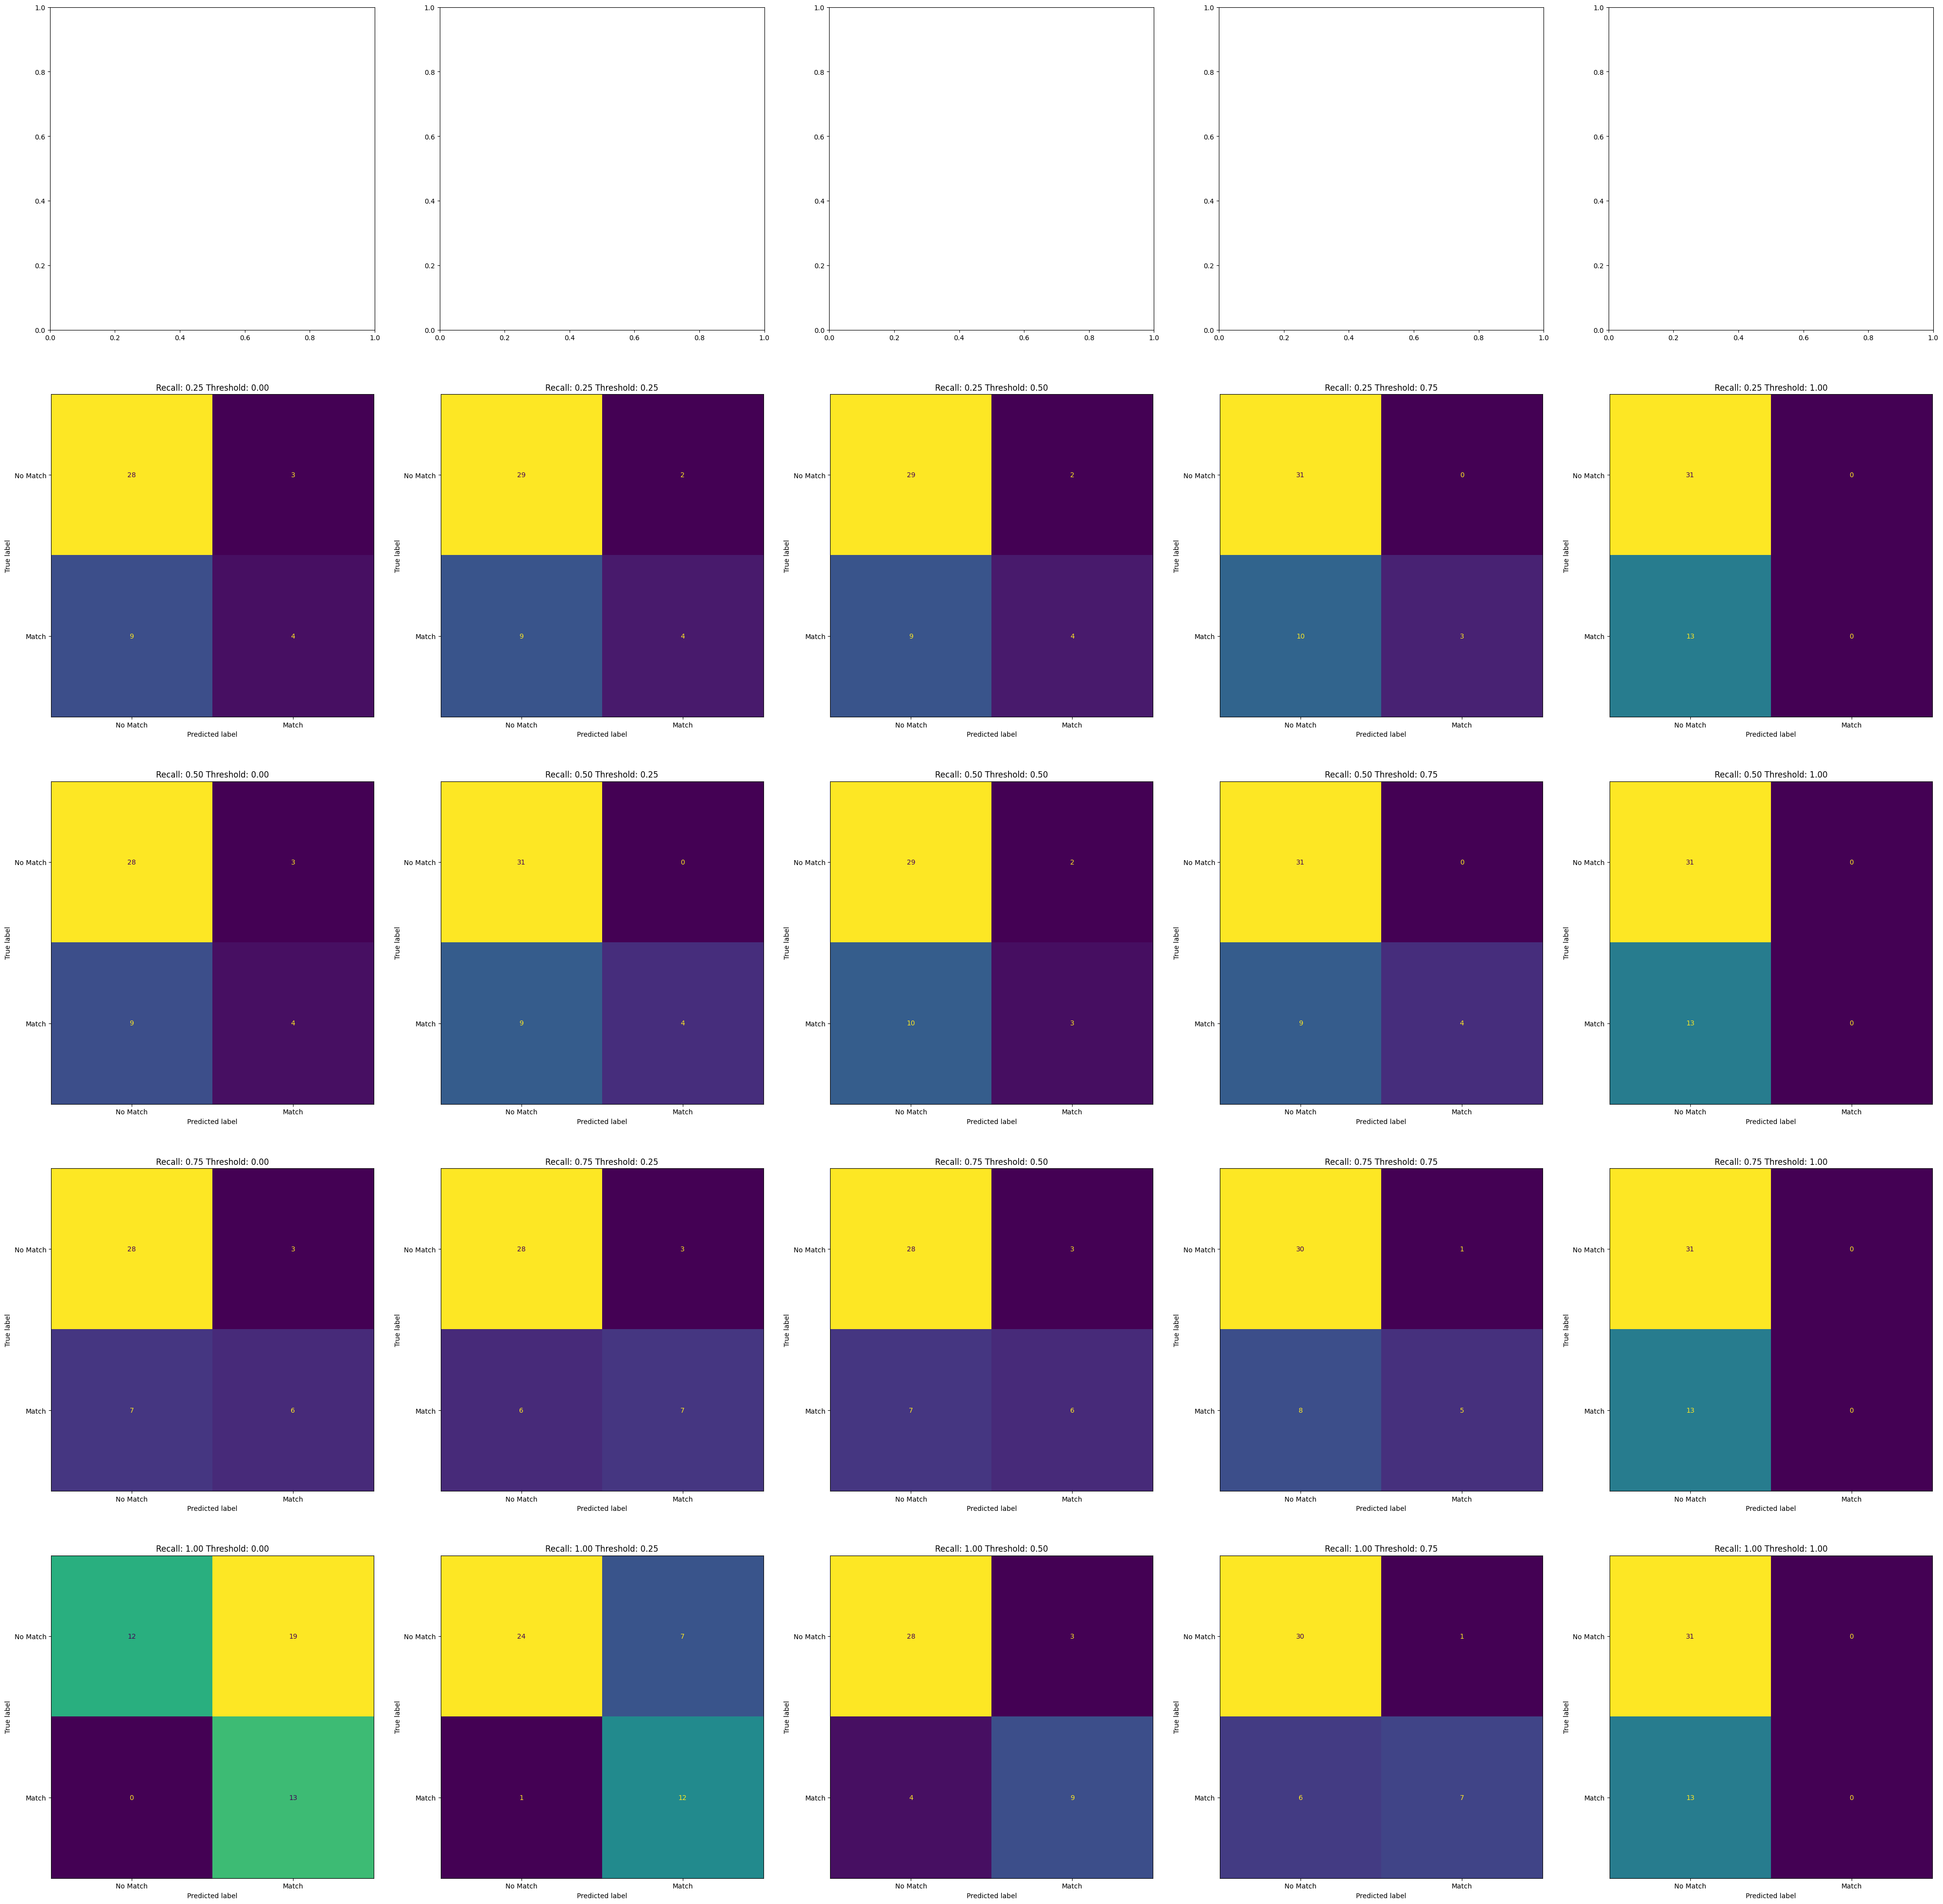

In [151]:
train_df = structures_df.loc[
    structures_df.index.isin(y_train.index.get_level_values(0))
    | structures_df.index.isin(y_train.index.get_level_values(1))
]
test_df = structures_df.loc[
    structures_df.index.isin(y_test.index.get_level_values(0))
    | structures_df.index.isin(y_test.index.get_level_values(1))
]

fig, axes = plt.subplots(5, 5, figsize=(50, 50))

for (recall, threshold), ax in zip(
    product(
        np.linspace(0, 1, 5),
        np.linspace(0, 1, 5),
    ),
    axes.flatten(),
):
    train_deduper = train_dedupe(
        X_train=train_df,
        y_train=y_train,
        input_df=structures_df,
        recall=recall,
    )

    try:
        clustered_dupes = train_deduper.partition(
            data=json.loads(test_df.to_json(orient="index")),
            threshold=threshold,
        )
    except dedupe.core.BlockingError:
        continue

    clusters_df = pd.DataFrame(
        data=[
            {"id": record_id, "cluster_id": cluster_id, "score": score}
            for cluster_id, (records, scores) in enumerate(clustered_dupes)
            for record_id, score in zip(records, scores)
        ]
    )

    y_pred_with_score = (
        clusters_df.merge(clusters_df, how="cross", suffixes=("_left", "_right"))
        .assign(
            score=lambda df: df["score_left"],
            left=lambda df: df[["id_left", "id_right"]].min(axis=1),
            right=lambda df: df[["id_left", "id_right"]].max(axis=1),
            label=lambda df: df.apply(
                lambda row: "match"
                if row["cluster_id_left"] == row["cluster_id_right"]
                else "distinct",
                axis=1,
            ),
        )[["left", "right", "label", "score"]]
        .drop_duplicates(keep="first")
        .set_index(["left", "right"])
        .loc[y_test.index]
    )

    y_pred = y_pred_with_score.drop(columns="score")
    y_pred = y_pred.loc[~y_pred.index.duplicated(keep="first")]

    ax.set_title(f"Recall: {recall:.2f} Threshold: {threshold:.2f}")
    cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
    disp = metrics.ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["No Match", "Match"]
    )
    disp.plot(ax=ax, colorbar=False)

### 4. Inference and evaluation for the selected model

The model files are the main artefacts of this training and can be loaded into the pipeline for inference.

Here we train our model with the selected parameters.

Things to check :

* cluster sizes should be relatively small (less than 100 elements)
* we want a high FP/TP ratio

In [ ]:
THRESHOLD = 0.75
RECALL = 1
INPUT_DATA = "https://console.scaleway.com/object-storage/buckets/fr-par/data-inclusion-datalake-prod-grand-titmouse/files/data/marts/2024-11-19/scheduled__2024-11-19T12%3A00%3A00%2B00%3A00/structures.parquet"

deduper = train_dedupe(
    X_train=train_df,
    y_train=y_train,
    input_df=structures_df,
    recall=RECALL,
)

clustered_dupes = deduper.partition(
    data=json.loads(test_df.to_json(orient="index")),
    threshold=THRESHOLD,
)

clusters_df = pd.DataFrame(
    data=[
        {"id": record_id, "cluster_id": cluster_id, "score": score}
        for cluster_id, (records, scores) in enumerate(clustered_dupes)
        for record_id, score in zip(records, scores)
    ]
)

deduper.write_settings(Path("./model.bin").open("wb"))
json.dump(
    {
        "threshold": THRESHOLD,
        "recall": RECALL,
        "input_data": INPUT_DATA,
    },
    Path("./metadata.json").open("w"),
    indent=4,
)

/home/vmttn/src/github.com/betagouv/data-inclusion/deduplication/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vmttn/src/github.com/betagouv/data-inclusion/deduplication/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alter

In [ ]:
clusters_df.value_counts("cluster_id").value_counts()

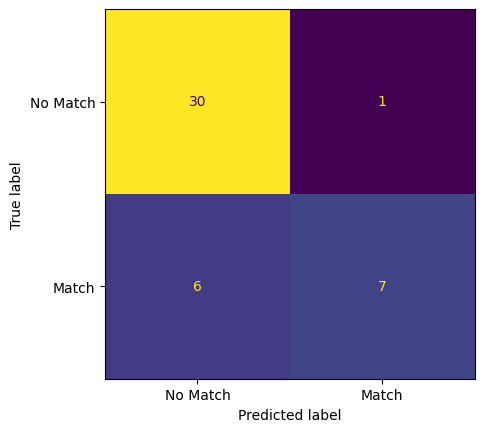

In [154]:
y_pred_with_score = (
    clusters_df.merge(clusters_df, how="cross", suffixes=("_left", "_right"))
    .assign(
        score=lambda df: df["score_left"],
        left=lambda df: df[["id_left", "id_right"]].min(axis=1),
        right=lambda df: df[["id_left", "id_right"]].max(axis=1),
        label=lambda df: df.apply(
            lambda row: "match"
            if row["cluster_id_left"] == row["cluster_id_right"]
            else "distinct",
            axis=1,
        ),
    )[["left", "right", "label", "score"]]
    .drop_duplicates(keep="first")
    .set_index(["left", "right"])
    .loc[y_test.index]
)

y_pred_with_score = y_pred_with_score.loc[
    ~y_pred_with_score.index.duplicated(keep="first")
]
y_pred = y_pred_with_score.drop(columns="score")

metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred,
    display_labels=["No Match", "Match"],
    colorbar=False,
)

In [155]:
print(metrics.classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

    distinct       0.83      0.97      0.90        31
       match       0.88      0.54      0.67        13

    accuracy                           0.84        44
   macro avg       0.85      0.75      0.78        44
weighted avg       0.85      0.84      0.83        44



In [158]:
clusters_df["cluster_id"].nunique()

50645

In [162]:
clusters_df.groupby("cluster_id").size().sort_values(ascending=False)

cluster_id
1383     11
1522      9
948       7
2346      7
2688      7
         ..
20084     1
20085     1
20086     1
20087     1
20076     1
Length: 50645, dtype: int64

In [163]:
clusters_df.groupby("cluster_id").size().value_counts()

1     45843
2      3600
3      1021
4        85
5        81
6         7
7         6
11        1
9         1
Name: count, dtype: int64

In [164]:
dup_clusters_df = clusters_df.loc[clusters_df["cluster_id"].duplicated(keep=False)]
dup_clusters_df = dup_clusters_df.set_index("id").join(structures_df).reset_index()

pairs_df = (
    dup_clusters_df.merge(
        dup_clusters_df,
        how="inner",
        suffixes=("_left", "_right"),
        on="cluster_id",
    )
    .assign(
        score=lambda df: df["score_left"],
        id_left=lambda df: df[["id_left", "id_right"]].min(axis=1),
        id_right=lambda df: df[["id_left", "id_right"]].max(axis=1),
        source_left=lambda df: df[["source_left", "source_right"]].min(axis=1),
        source_right=lambda df: df[["source_left", "source_right"]].max(axis=1),
        label="match",
    )
    .drop_duplicates(keep="first", subset=["id_left", "id_right"])
)
pairs_df = pairs_df.loc[pairs_df["id_left"] != pairs_df["id_right"]]
pairs_df = pairs_df[["source_left", "source_right", "score", "cluster_id"]]

In [165]:
sources = (
    pd.concat([pairs_df["source_left"], pairs_df["source_right"]])
    .sort_values()
    .unique()
)

pairs_df.value_counts(["source_left", "source_right"]).unstack(fill_value=0).reindex(
    labels=sources, fill_value=0
)

source_right,action-logement,dora,emplois-de-linclusion,france-travail,mediation-numerique,mes-aides,soliguide
source_left,,,,,,,
action-logement,8,2,0,0,0,0,0
dora,0,39,2338,860,510,51,395
emplois-de-linclusion,0,0,661,643,690,49,130
france-travail,0,0,0,1,11,0,0
mediation-numerique,0,0,0,0,1046,99,689
mes-aides,0,0,0,0,0,28,28
soliguide,0,0,0,0,0,0,27


👇 analyzing the `score` output to see if we should also filter by score

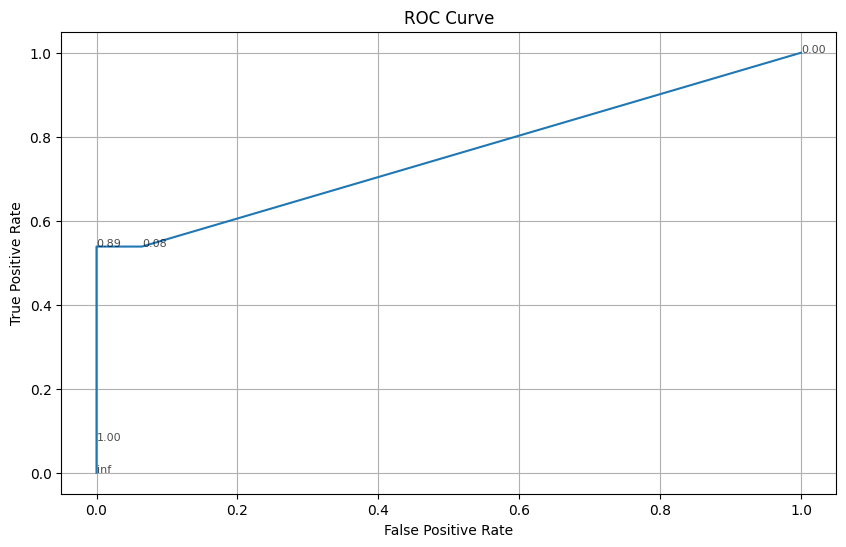

In [156]:
fpr, tpr, scores = metrics.roc_curve(
    y_true=y_test,
    y_score=y_pred_with_score.assign(
        score=lambda df: np.where(df["label"] == "match", df["score"], 1 - df["score"])
    )["score"],
    pos_label="match",
)


plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()

for i, score in enumerate(scores):
    plt.annotate(f"{score:.2f}", (fpr[i], tpr[i]), fontsize=8, alpha=0.7)

plt.show()